In [1]:
import cPickle

# PARAMS
log_dir = "/home/sforesti/avakas/scratch/sforestier001/logs/CogSci2017/2017-01-17_19-32-17-EXPLO-0.5"


filename = log_dir + '/results/competence.pickle'
with open(filename, 'r') as f:
    data_competence = cPickle.load(f)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

config_list = ["RMB"]
n_trial = 100
n_goals = 100
trial_list = range(1,n_trial + 1) 
config_name = "RMB"


data_gavd = {}

for trial in trial_list:
    data_gavd[trial] = {}
    for region in [1, 2, 3]:
        data_gavd[trial][region] = {}
        for toy in ["toy1", "toy2", "toy3"]:
            data_gavd[trial][region][toy] = {}
            data_gavd[trial][region][toy]["comp_error"] = np.mean([data_competence[config_name][trial]["eval_results"][region][i][toy]["comp_error"] for i in range(n_goals)])
            data_gavd[trial][region][toy]["arm_dist"] = np.mean([data_competence[config_name][trial]["eval_results"][region][i][toy]["arm_dist"] for i in range(n_goals)])
            data_gavd[trial][region][toy]["diva_dist"] = np.mean([data_competence[config_name][trial]["eval_results"][region][i][toy]["diva_dist"] for i in range(n_goals)])
            data_gavd[trial][region][toy]["reached"] = np.mean([data_competence[config_name][trial]["eval_results"][region][i][toy]["reached"] for i in range(n_goals)])

In [3]:
bins = 100

map_comp = np.zeros((bins, bins))
map_hand = np.zeros((bins, bins))
map_tool = np.zeros((bins, bins))
map_vocal = np.zeros((bins, bins))

min_2d = [-1.,  -1.]
max_2d = [1.,  1.]

def real2map(x, y):
    i = int((x - min_2d[0]) / (max_2d[0] - min_2d[0]) * 100.)
    j = int((y - min_2d[0]) / (max_2d[0] - min_2d[0]) * 100.)
    i = max(0, min(i, 99))
    j = max(0, min(j, 99))
    return i, j

for trial in trial_list:
    for region in [1, 2, 3]:
        for gi in range(n_goals):
            for toy in ["toy1", "toy2", "toy3"]:
                x, y = data_competence[config_name][trial]["eval_results"][region][gi][toy]["toy_pos"]
                i, j = real2map(x, y)
                map_comp[i, j] += data_competence[config_name][trial]["eval_results"][region][gi][toy]["comp_error"]
                if data_competence[config_name][trial]["eval_results"][region][gi][toy]["arm_dist"] < data_competence[config_name][trial]["eval_results"][region][gi][toy]["diva_dist"]:
                    if data_competence[config_name][trial]["eval_results"][region][gi][toy]["tool"]:
                        map_tool[i, j] += 1
                    else:
                        map_hand[i, j] += 1
                else:      
                    map_vocal[i, j] += 1
        
for i in range(bins):
    for j in range(bins):
        n = map_hand[i, j] + map_tool[i, j] + map_vocal[i, j]
        if n > 0:
            map_comp[i, j] /= n
        else:
            map_comp[i, j] = -1
    
map_total = map_hand + map_tool + map_vocal

for i in range(bins):
    for j in range(bins):
        if map_total[i, j]:
            map_hand[i, j] /= map_total[i, j]
            map_tool[i, j] /= map_total[i, j]
            map_vocal[i, j] /= map_total[i, j]
#        if (i - bins/2.)**2. + (j - bins/2.)**2. > bins*bins/4.:
#            map_hand[i, j] = -1
#            map_tool[i, j] = -1
#            map_vocal[i, j] = -1
            

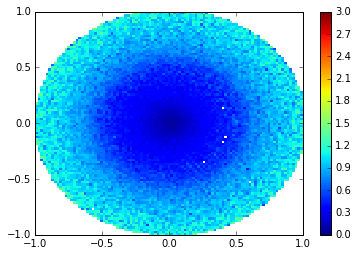

In [57]:

x_points = np.linspace(-1., 1., bins)
y_points = np.linspace(-1., 1., bins)

pcol = plt.pcolormesh(x_points, y_points, map_comp, vmin=0, vmax=3., linewidth=0, cmap="jet")  
pcol.set_rasterized(True)      
pcol.set_edgecolor('face')

pcol.cmap.set_under('white')

cb = plt.colorbar()
#cb.ax.set_yticklabels(["Tool", "", "", "", "", "", "", "", "", "", "Hand"], fontsize = 30)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")

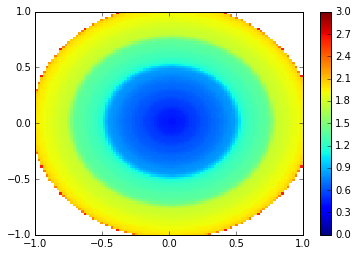

In [59]:
# GET MOTOR BABBLING ERROR MAP
import cPickle

filename = '../data/motor_babbling.pickle'
with open(filename, 'r') as f:
    map_comp_mb_avg = cPickle.load(f)
f.close()

pcol = plt.pcolormesh(x_points, y_points, map_comp_mb_avg, vmin=0, vmax=3., linewidth=0, cmap="jet")  
pcol.set_rasterized(True)      
pcol.set_edgecolor('face')

pcol.cmap.set_under('white')

cb = plt.colorbar()
#cb.ax.set_yticklabels(["Tool", "", "", "", "", "", "", "", "", "", "Hand"], fontsize = 30)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")

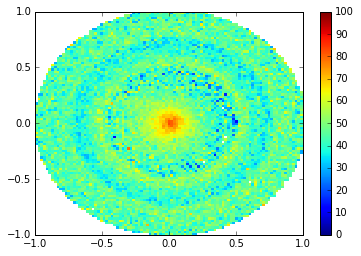

In [60]:
# NORMALIZE COMPETENCE MAP WITH MOTOR BABBLING MAP
map_comp_norm = np.zeros((bins, bins))

for i in range(bins):
    for j in range(bins):
        if map_comp[i, j] < 0. or np.isnan(map_comp_mb_avg[i, j]):
            map_comp_norm[i, j] = -1.
        else:
            map_comp_norm[i, j] = max(0., 1. - map_comp[i, j] / map_comp_mb_avg[i, j])
  
x_points = np.linspace(-1., 1., bins)
y_points = np.linspace(-1., 1., bins)

pcol = plt.pcolormesh(x_points, y_points, 100.* map_comp_norm, vmin=0., vmax=100., linewidth=0, cmap="jet")  
pcol.set_rasterized(True)      
pcol.set_edgecolor('face')

pcol.cmap.set_under('white')

cb = plt.colorbar()
#cb.ax.set_yticklabels(["Tool", "", "", "", "", "", "", "", "", "", "Hand"], fontsize = 30)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")          
            

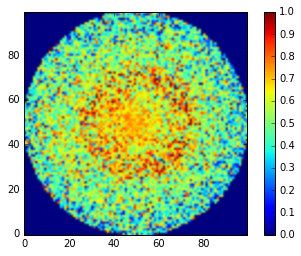

In [5]:
plt.imshow(map_hand, origin = "lower", interpolation = "gaussian")
cb = plt.colorbar()

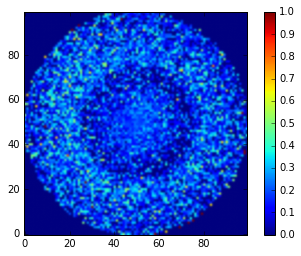

In [6]:
plt.imshow(map_tool, origin = "lower", interpolation = "gaussian")
cb = plt.colorbar()

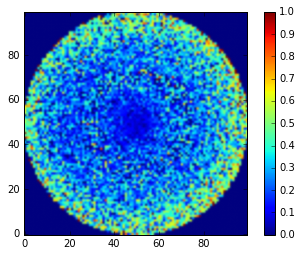

In [7]:
plt.imshow(map_vocal, origin = "lower", interpolation = "gaussian")
cb = plt.colorbar()